# NLP Commodities Price Prediction

## Data Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [122]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from dotenv import load_dotenv
from huggingface_hub import InferenceClient
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from tqdm.notebook import tqdm

import utils

In [60]:
load_dotenv()

model = os.getenv("model")
client = InferenceClient(model + "/v1/chat/completions", token=os.getenv("api_token"))

In [10]:
tqdm.pandas()

### Historical Data

In [11]:
hist_data = pd.read_csv('../data/historical data.csv')
hist_data

,Date,SPY_adj_close,SPY return,DIA_adj_close,DIA return,QQQ_adj_close,QQQ return,crude_oil,CPI,Fed Fund Rate,crude_oil_return,BTC-USD,^VIX,FSPSX,FSPSX_return,usd_index
0,2011-08-12,92.504018,0.006733,84.860400,0.013933,47.440430,0.008851,108.17,226.545,0.10,0.003246,NaN,36.360001,NaN,NaN,74.610001
1,2011-08-15,94.461858,0.021165,86.372540,0.017819,48.140037,0.014747,108.89,226.545,0.10,0.006656,NaN,31.870001,NaN,NaN,73.839996
2,2011-08-16,93.655228,-0.008539,85.823355,-0.006358,47.732671,-0.008462,109.69,226.545,0.09,0.007347,NaN,32.849998,NaN,NaN,74.010002
3,2011-08-17,93.717879,0.000669,85.958770,0.001578,47.449286,-0.005937,111.37,226.545,0.09,0.015316,NaN,31.580000,NaN,NaN,73.669998
4,2011-08-18,89.676897,-0.043119,82.806598,-0.036671,45.120215,-0.049085,108.36,226.545,0.09,-0.027027,NaN,42.669998,NaN,NaN,74.239998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,421.953285,0.001652,331.343811,0.004221,360.426156,-0.004382,71.02,273.567,0.10,-0.015525,42816.500000,16.150000,46.287758,-0.005122,92.800003
2513,2021-08-09,421.609993,-0.000814,330.459198,-0.002670,361.092071,0.001848,69.65,273.567,0.10,-0.019290,46365.402344,16.719999,46.296921,0.000198,92.949997
2514,2021-08-10,422.134467,0.001244,331.946100,0.004500,359.241221,-0.005126,71.14,273.567,0.10,0.021393,45585.031250,16.790001,46.388580,0.001980,93.059998
2515,2021-08-11,423.183414,0.002485,334.025880,0.006265,358.624270,-0.001717,71.99,273.567,0.10,0.011948,45593.636719,16.170000,46.727718,0.007311,92.910004


In [12]:
# drop adj close columns
hist_data = hist_data.drop(columns=['SPY_adj_close', 'DIA_adj_close', 'QQQ_adj_close', 'crude_oil', 'BTC-USD', 'FSPSX'])
hist_data

,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,^VIX,FSPSX_return,usd_index
0,2011-08-12,0.006733,0.013933,0.008851,226.545,0.10,0.003246,36.360001,NaN,74.610001
1,2011-08-15,0.021165,0.017819,0.014747,226.545,0.10,0.006656,31.870001,NaN,73.839996
2,2011-08-16,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,32.849998,NaN,74.010002
3,2011-08-17,0.000669,0.001578,-0.005937,226.545,0.09,0.015316,31.580000,NaN,73.669998
4,2011-08-18,-0.043119,-0.036671,-0.049085,226.545,0.09,-0.027027,42.669998,NaN,74.239998
...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,16.150000,-0.005122,92.800003
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,16.719999,0.000198,92.949997
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,16.790001,0.001980,93.059998
2515,2021-08-11,0.002485,0.006265,-0.001717,273.567,0.10,0.011948,16.170000,0.007311,92.910004


In [13]:
# calculate return for vix and usd_index
hist_data['vix_return'] = hist_data['^VIX'].pct_change()
hist_data['usd_index_return'] = hist_data['usd_index'].pct_change()
# drop adj close columns
hist_data = hist_data.drop(columns=['^VIX', 'usd_index'])
hist_data

/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_91807/3510675308.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hist_data['vix_return'] = hist_data['^VIX'].pct_change()
/var/folders/8b/9mzlkxlx3zx9nmpy8prjpmm80000gn/T/ipykernel_91807/3510675308.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hist_data['usd_index_return'] = hist_data['usd_index'].pct_change()


,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
0,2011-08-12,0.006733,0.013933,0.008851,226.545,0.10,0.003246,NaN,NaN,NaN
1,2011-08-15,0.021165,0.017819,0.014747,226.545,0.10,0.006656,NaN,-0.123487,-0.010320
2,2011-08-16,-0.008539,-0.006358,-0.008462,226.545,0.09,0.007347,NaN,0.030750,0.002302
3,2011-08-17,0.000669,0.001578,-0.005937,226.545,0.09,0.015316,NaN,-0.038661,-0.004594
4,2011-08-18,-0.043119,-0.036671,-0.049085,226.545,0.09,-0.027027,NaN,0.351172,0.007737
...,...,...,...,...,...,...,...,...,...,...
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,-0.005122,-0.065394,0.006071
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,0.000198,0.035294,0.001616
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,0.001980,0.004187,0.001183
2515,2021-08-11,0.002485,0.006265,-0.001717,273.567,0.10,0.011948,0.007311,-0.036927,-0.001612


In [14]:
# drop rows with NaN
hist_data = hist_data.dropna()
hist_data

,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
19,2011-09-09,-0.026210,-0.027022,-0.022247,226.889,0.09,-0.024494,-0.033238,0.122378,0.012461
20,2011-09-12,0.006470,0.006283,0.012787,226.889,0.09,-0.003041,-0.015207,0.001817,0.004923
21,2011-09-13,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508
22,2011-09-14,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040
23,2011-09-15,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679
...,...,...,...,...,...,...,...,...,...,...
2511,2021-08-05,0.006333,0.007529,0.006343,273.567,0.10,0.016199,0.003956,-0.038397,-0.000325
2512,2021-08-06,0.001652,0.004221,-0.004382,273.567,0.10,-0.015525,-0.005122,-0.065394,0.006071
2513,2021-08-09,-0.000814,-0.002670,0.001848,273.567,0.10,-0.019290,0.000198,0.035294,0.001616
2514,2021-08-10,0.001244,0.004500,-0.005126,273.567,0.10,0.021393,0.001980,0.004187,0.001183


### Sentiment Data

In [15]:
sentiment_data = pd.read_csv('../data/Gold Dataset.csv')
sentiment_data

,Dates,URL,News
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,6/9/2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,7/1/2013,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,27-09-2018,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,3/3/2017,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,11/6/2008,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [16]:
# change date format to match historical data
sentiment_data['Dates'] = pd.to_datetime(sentiment_data['Dates'], format='mixed', errors='coerce').dt.strftime(
    '%Y-%m-%d')
sentiment_data

,Dates,URL,News
0,2016-01-28,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,2017-09-13,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,2016-07-26,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,2018-02-28,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,2017-06-09,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,2013-07-01,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,2018-09-27,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,2017-03-03,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,2008-11-06,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [17]:
# drop rows with NaN
sentiment_data = sentiment_data.dropna()
sentiment_data

,Dates,URL,News
0,2016-01-28,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1..."
1,2017-09-13,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline
2,2016-07-26,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline
3,2018-02-28,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...
4,2017-06-09,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers..."
...,...,...,...
10565,2013-07-01,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week
10566,2018-09-27,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...
10567,2017-03-03,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...
10568,2008-11-06,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex


In [18]:
# sort data by date
sentiment_data = sentiment_data.sort_values('Dates')

In [19]:
# drop URL column
sentiment_data = sentiment_data.drop(columns=['URL'])

#### Calculate Sentiment Polarity and Subjectivity

In [78]:
# fix text spelling/grammar
sentiment_data['Polarity'] = sentiment_data['News'].progress_apply(lambda x: TextBlob(x).correct().sentiment.polarity)
sentiment_data['Subjectivity'] = sentiment_data['News'].progress_apply(
    lambda x: TextBlob(x).correct().sentiment.subjectivity)

sentiment_data

  0%|          | 0/10405 [00:00<?, ?it/s]

  0%|          | 0/10405 [00:00<?, ?it/s]

,Dates,News,Topic,Classification,News Volume,Polarity,Subjectivity
4429,2000-01-11,gold slightly lower on dollar moves,2,Past,6,-0.166667,0.166667
4296,2000-02-15,gold is poised for greatness,4,Future,5,0.000000,0.000000
9738,2000-02-17,gold falls on technical pull back,4,Past,6,0.000000,0.050000
1898,2000-03-24,gold quiet on lack of market news,4,Past,7,0.000000,0.333333
8740,2000-04-05,gold and silver stocks in relief rally,0,Future,7,0.000000,0.000000
...,...,...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 tonnes in 2018,0,Past,12,0.100000,0.300000
10303,2019-07-01,china 's gold reserves rise for 1st time in over two years in dec,0,Past,14,0.000000,0.000000
1421,2019-09-01,Gold edges lower on improved risk appetite,0,Past,7,0.100000,0.200000
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,1,Future,7,0.100000,0.200000


#### Classify Past or Future Movement

In [73]:
# Function for classification
def classify_headline(headline):
    conversation = [
        {"role": "system", "content": "You are an assistant helping with text classification."},
        {
            "role": "user",
            "content": f"Classify each of the following texts into either 'Future' or 'Past' price movement. Respond only with 'Future' or 'Past' for this headline WITHOUT an explanation: {headline}"
        }
    ]
    response = client.chat_completion(
        messages=conversation,
        max_tokens=1,
        seed=42,
        temperature=0
    )
    return response.choices[0].message.content

In [74]:
# classify headlines
sentiment_data['Classification'] = sentiment_data['News'].progress_apply(classify_headline)

  0%|          | 0/10405 [00:00<?, ?it/s]

,Dates,News,Movement,Topic,Classification
4429,2000-01-11,gold slightly lower on dollar moves,Uncertain,2,Past
4296,2000-02-15,gold is poised for greatness,Uncertain,4,Future
9738,2000-02-17,gold falls on technical pull back,Uncertain,4,Past
1898,2000-03-24,gold quiet on lack of market news,Uncertain,4,Past
8740,2000-04-05,gold and silver stocks in relief rally,Uncertain,0,Future
...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 tonnes in 2018,Uncertain,0,Past
10303,2019-07-01,china 's gold reserves rise for 1st time in over two years in dec,Uncertain,0,Past
1421,2019-09-01,Gold edges lower on improved risk appetite,Uncertain,0,Past
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,Uncertain,1,Future


In [76]:
sentiment_data

,Dates,News,Topic,Classification
4429,2000-01-11,gold slightly lower on dollar moves,2,Past
4296,2000-02-15,gold is poised for greatness,4,Future
9738,2000-02-17,gold falls on technical pull back,4,Past
1898,2000-03-24,gold quiet on lack of market news,4,Past
8740,2000-04-05,gold and silver stocks in relief rally,0,Future
...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 tonnes in 2018,0,Past
10303,2019-07-01,china 's gold reserves rise for 1st time in over two years in dec,0,Past
1421,2019-09-01,Gold edges lower on improved risk appetite,0,Past
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,1,Future


#### Calculate News Volume

In [77]:
# calculate news volume per day
sentiment_data['News Volume'] = sentiment_data['News'].progress_apply(lambda x: len(x.split()))
sentiment_data

  0%|          | 0/10405 [00:00<?, ?it/s]

,Dates,News,Topic,Classification,News Volume
4429,2000-01-11,gold slightly lower on dollar moves,2,Past,6
4296,2000-02-15,gold is poised for greatness,4,Future,5
9738,2000-02-17,gold falls on technical pull back,4,Past,6
1898,2000-03-24,gold quiet on lack of market news,4,Past,7
8740,2000-04-05,gold and silver stocks in relief rally,0,Future,7
...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 tonnes in 2018,0,Past,12
10303,2019-07-01,china 's gold reserves rise for 1st time in over two years in dec,0,Past,14
1421,2019-09-01,Gold edges lower on improved risk appetite,0,Past,7
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,1,Future,7


#### Calculate Positive/Neutral/Negative Word Count

In [84]:
# calculate positive word count
sentiment_data['Positive Word Count'] = sentiment_data['News'].progress_apply(
    lambda x: len([word for word in x.split() if TextBlob(word).correct().sentiment.polarity > 0]))
# calculate neutral word count
sentiment_data['Neutral Word Count'] = sentiment_data['News'].progress_apply(
    lambda x: len([word for word in x.split() if TextBlob(word).correct().sentiment.polarity == 0]))
# calculate negative word count
sentiment_data['Negative Word Count'] = sentiment_data['News'].progress_apply(
    lambda x: len([word for word in x.split() if TextBlob(word).correct().sentiment.polarity < 0]))

sentiment_data

  0%|          | 0/10405 [00:00<?, ?it/s]

  0%|          | 0/10405 [00:00<?, ?it/s]

  0%|          | 0/10405 [00:00<?, ?it/s]

,Dates,News,Topic,Classification,News Volume,Polarity,Subjectivity,Polarity MA,Subjectivity MA,Positive Word Count,Neutral Word Count,Negative Word Count
4429,2000-01-11,gold slightly lower on dollar moves,2,Past,6,-0.166667,0.166667,NaN,NaN,0,5,1
4296,2000-02-15,gold is poised for greatness,4,Future,5,0.000000,0.000000,NaN,NaN,0,5,0
9738,2000-02-17,gold falls on technical pull back,4,Past,6,0.000000,0.050000,NaN,NaN,0,6,0
1898,2000-03-24,gold quiet on lack of market news,4,Past,7,0.000000,0.333333,NaN,NaN,0,7,0
8740,2000-04-05,gold and silver stocks in relief rally,0,Future,7,0.000000,0.000000,-0.033333,0.110000,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7709,2019-04-01,etfs : gld sees gold holdings drop nearly 50 tonnes in 2018,0,Past,12,0.100000,0.300000,0.100000,0.340000,2,10,0
10303,2019-07-01,china 's gold reserves rise for 1st time in over two years in dec,0,Past,14,0.000000,0.000000,0.100000,0.290000,0,14,0
1421,2019-09-01,Gold edges lower on improved risk appetite,0,Past,7,0.100000,0.200000,0.120000,0.330000,1,6,0
4050,2019-09-01,Gold up Rs 110 on jewellers' buying,1,Future,7,0.100000,0.200000,0.140000,0.300000,1,6,0


In [142]:
# merge historical data on sentiment data
df = pd.merge(sentiment_data, hist_data, how='left', left_on='Dates', right_on='Date')
df

,Dates,News,Classification,News Volume,Polarity,Subjectivity,Positive Word Count,Neutral Word Count,Negative Word Count,Date,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
0,2000-01-11,gold slightly lower on dollar moves,Past,6,-0.166667,0.166667,0,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-15,gold is poised for greatness,Future,5,0.000000,0.000000,0,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-02-17,gold falls on technical pull back,Past,6,0.000000,0.050000,0,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-03-24,gold quiet on lack of market news,Past,7,0.000000,0.333333,0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-04-05,gold and silver stocks in relief rally,Future,7,0.000000,0.000000,0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,2019-04-01,etfs : gld sees gold holdings drop nearly 50 tonnes in 2018,Past,12,0.100000,0.300000,2,10,0,2019-04-01,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308
10401,2019-07-01,china 's gold reserves rise for 1st time in over two years in dec,Past,14,0.000000,0.000000,0,14,0,2019-07-01,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386
10402,2019-09-01,Gold edges lower on improved risk appetite,Past,7,0.100000,0.200000,1,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10403,2019-09-01,Gold up Rs 110 on jewellers' buying,Future,7,0.100000,0.200000,1,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Gold Price

In [139]:
gold_price = pd.read_csv('../data/Gold Historical Data.csv')
gold_price

,Date,Close/Last,Volume,Open,High,Low
0,08/12/2021,1751.8,133990.0,1752.9,1759.6,1742.6
1,08/11/2021,1753.3,181306.0,1730.4,1756.7,1724.6
2,08/10/2021,1731.7,178253.0,1732.0,1739.4,1718.5
3,08/09/2021,1726.5,282388.0,1765.0,1765.7,1677.9
4,08/06/2021,1763.1,305778.0,1806.7,1807.0,1759.5
...,...,...,...,...,...,...
2554,08/18/2011,1822.0,197469.0,1818.0,1830.6,1786.8
2555,08/17/2011,1793.8,125321.0,1790.0,1797.6,1781.8
2556,08/16/2011,1785.0,148533.0,1780.8,1789.2,1763.6
2557,08/15/2011,1758.0,110191.0,1741.3,1767.8,1730.9


In [140]:
# change date format to match historical data
gold_price['Date'] = pd.to_datetime(gold_price['Date'], format='mixed', errors='coerce').dt.strftime('%Y-%m-%d')
gold_price

,Date,Close/Last,Volume,Open,High,Low
0,2021-08-12,1751.8,133990.0,1752.9,1759.6,1742.6
1,2021-08-11,1753.3,181306.0,1730.4,1756.7,1724.6
2,2021-08-10,1731.7,178253.0,1732.0,1739.4,1718.5
3,2021-08-09,1726.5,282388.0,1765.0,1765.7,1677.9
4,2021-08-06,1763.1,305778.0,1806.7,1807.0,1759.5
...,...,...,...,...,...,...
2554,2011-08-18,1822.0,197469.0,1818.0,1830.6,1786.8
2555,2011-08-17,1793.8,125321.0,1790.0,1797.6,1781.8
2556,2011-08-16,1785.0,148533.0,1780.8,1789.2,1763.6
2557,2011-08-15,1758.0,110191.0,1741.3,1767.8,1730.9


In [143]:
# merge gold return with merged data
df = pd.merge(gold_price[['Date', 'Close/Last']], df, how='left', left_on='Date', right_on='Dates')
df

,Date_x,Close/Last,Dates,News,Classification,News Volume,Polarity,Subjectivity,Positive Word Count,Neutral Word Count,...,Date_y,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
0,2021-08-12,1751.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-11,1753.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-10,1731.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-09,1726.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-06,1763.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7410,2011-08-15,1758.0,2011-08-15,"dec. gold rallies $13.60 to $1,756.20/oz in ny",Past,8.0,0.000000,0.000000,0.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7411,2011-08-12,1742.6,2011-08-12,MCX GOLDGUINEA Dec contract gains,Future,5.0,0.000000,0.000000,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7412,2011-08-12,1742.6,2011-08-12,MCX GOLD June contract firms up,Future,6.0,0.000000,0.000000,0.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7413,2011-08-12,1742.6,2011-08-12,"Old for new gold, is the wedding mantra",Past,8.0,0.118182,0.327273,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
# drop rows with NaN
df = df.dropna()

# drop Dates column and rename Date_x to Date
df = df.drop(columns=['Dates', 'Date_y'])
df = df.rename(columns={'Date_x': 'Date'})
df

,Date,Close/Last,News,Classification,News Volume,Polarity,Subjectivity,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
447,2019-11-01,1508.0,Gold futures up Rs 120 on positive global cues,Future,9.0,0.081818,0.217614,2.0,7.0,0.0,0.009264,0.010574,0.009083,257.208,1.57,0.014671,0.008493,-0.069592,-0.001130
534,2019-07-01,1385.6,china 's gold reserves rise for 1st time in over two years in dec,Past,14.0,0.000000,0.000000,0.0,14.0,0.0,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386
597,2019-04-01,1294.2,cpm group : politics expected to drive gold volatility in early 2019,Future,12.0,0.000000,0.350000,1.0,10.0,1.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308
598,2019-04-01,1294.2,free : interactive gold charts here ...,Future,7.0,0.400000,0.800000,1.0,6.0,0.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308
599,2019-04-01,1294.2,etfs : gld sees gold holdings drop nearly 50 tonnes in 2018,Past,12.0,0.100000,0.300000,2.0,10.0,0.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,2011-09-15,1781.4,"gold futures add to losses, down $32 to $1,795",Past,9.0,-0.077778,0.206944,0.0,8.0,1.0,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679
7347,2011-09-15,1781.4,"dec gold futures tumble $21.10 to $1,805.40/ounce",Past,7.0,0.000000,0.125000,0.0,7.0,0.0,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679
7348,2011-09-14,1826.5,crude-oil futures decline as gold rises modestly,Future,7.0,0.050000,0.512500,1.0,6.0,0.0,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040
7349,2011-09-13,1830.1,crude advances; gold slips more than 2%,Past,7.0,-0.100000,0.750000,1.0,5.0,1.0,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508


## Explanatory Data Analysis

In [145]:
# Describe data
df.describe()

,Close/Last,News Volume,Polarity,Subjectivity,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
count,6380.000000,6380.000000,6380.000000,6380.000000,6380.000000,6380.000000,6380.000000,6380.000000,6380.000000,6380.000000,6380.000000,6380.00000,6380.000000,6380.000000,6380.000000,6380.000000
mean,1329.986458,9.276019,0.033481,0.218978,0.687618,8.351881,0.236520,0.000685,0.000728,0.000852,240.777913,0.72215,0.000607,0.000366,0.003330,0.000011
std,165.007342,2.256930,0.155122,0.212358,0.792505,2.290784,0.463107,0.008505,0.008283,0.010542,7.563550,0.66536,0.018951,0.009148,0.087791,0.004379
min,1049.600000,2.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,-0.041822,-0.045738,-0.045767,225.672000,0.04000,-0.077645,-0.083516,-0.259057,-0.017454
25%,1230.200000,8.000000,0.000000,0.000000,0.000000,7.000000,0.000000,-0.002618,-0.002664,-0.003639,234.722000,0.13000,-0.009427,-0.003859,-0.041026,-0.002683
50%,1281.700000,9.000000,0.000000,0.200000,1.000000,8.000000,0.000000,0.000637,0.000820,0.001195,241.428000,0.41000,0.000443,0.000495,-0.004630,0.000000
75%,1338.000000,11.000000,0.100000,0.325568,1.000000,10.000000,0.000000,0.004751,0.004523,0.006354,246.663000,1.16000,0.010276,0.005034,0.032863,0.002538
max,1830.100000,21.000000,1.000000,1.000000,5.000000,21.000000,3.000000,0.050525,0.048647,0.062439,257.208000,2.41000,0.104023,0.054254,1.155979,0.020528


In [146]:
# drop any classification rows that are not 'Future' or 'Past'
df = df[(df['Classification'] == 'Future') | (df['Classification'] == 'Past')]

### Feature Engineering

In [148]:
# Split data into features and target
X = df.drop(columns=['Date', 'Close/Last', 'News'])
y = df['Close/Last']
X

,Classification,News Volume,Polarity,Subjectivity,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return
447,Future,9.0,0.081818,0.217614,2.0,7.0,0.0,0.009264,0.010574,0.009083,257.208,1.57,0.014671,0.008493,-0.069592,-0.001130
534,Past,14.0,0.000000,0.000000,0.0,14.0,0.0,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386
597,Future,12.0,0.000000,0.350000,1.0,10.0,1.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308
598,Future,7.0,0.400000,0.800000,1.0,6.0,0.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308
599,Past,12.0,0.100000,0.300000,2.0,10.0,0.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,Past,9.0,-0.077778,0.206944,0.0,8.0,1.0,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679
7347,Past,7.0,0.000000,0.125000,0.0,7.0,0.0,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679
7348,Future,7.0,0.050000,0.512500,1.0,6.0,0.0,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040
7349,Past,7.0,-0.100000,0.750000,1.0,5.0,1.0,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508


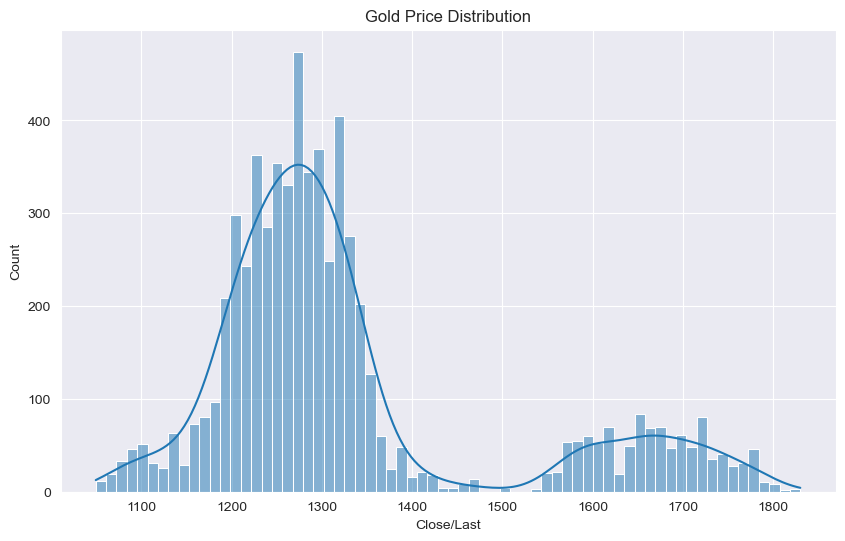

In [150]:
# plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Gold Price Distribution')
plt.show()

#### Dummy Variables

In [151]:
# create dummy variables
X = pd.get_dummies(X, columns=['Classification'])
X

,News Volume,Polarity,Subjectivity,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return,Classification_Future,Classification_Past
447,9.0,0.081818,0.217614,2.0,7.0,0.0,0.009264,0.010574,0.009083,257.208,1.57,0.014671,0.008493,-0.069592,-0.001130,True,False
534,14.0,0.000000,0.000000,0.0,14.0,0.0,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386,False,True
597,12.0,0.000000,0.350000,1.0,10.0,1.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,True,False
598,7.0,0.400000,0.800000,1.0,6.0,0.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,True,False
599,12.0,0.100000,0.300000,2.0,10.0,0.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,9.0,-0.077778,0.206944,0.0,8.0,1.0,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679,False,True
7347,7.0,0.000000,0.125000,0.0,7.0,0.0,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679,False,True
7348,7.0,0.050000,0.512500,1.0,6.0,0.0,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040,True,False
7349,7.0,-0.100000,0.750000,1.0,5.0,1.0,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508,False,True


In [152]:
# convert dummy variables to binary
X['Classification_Future'] = X['Classification_Future'].apply(lambda x: 1 if x == 1 else 0)
X['Classification_Past'] = X['Classification_Past'].apply(lambda x: 1 if x == 1 else 0)

In [153]:
X = X.drop(columns=['Classification_Past'])
X

,News Volume,Polarity,Subjectivity,Positive Word Count,Neutral Word Count,Negative Word Count,SPY return,DIA return,QQQ return,CPI,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return,Classification_Future
447,9.0,0.081818,0.217614,2.0,7.0,0.0,0.009264,0.010574,0.009083,257.208,1.57,0.014671,0.008493,-0.069592,-0.001130,1
534,14.0,0.000000,0.000000,0.0,14.0,0.0,0.009078,0.004213,0.013495,256.571,2.39,-0.035841,0.004109,-0.067639,0.007386,0
597,12.0,0.000000,0.350000,1.0,10.0,1.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,1
598,7.0,0.400000,0.800000,1.0,6.0,0.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,1
599,12.0,0.100000,0.300000,2.0,10.0,0.0,0.011859,0.012581,0.013247,255.548,2.41,0.016929,0.011503,-0.022611,-0.000308,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,9.0,-0.077778,0.206944,0.0,8.0,1.0,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679,0
7347,7.0,0.000000,0.125000,0.0,7.0,0.0,0.017257,0.016548,0.014812,226.889,0.09,0.031919,0.021989,-0.076012,-0.007679,0
7348,7.0,0.050000,0.512500,1.0,6.0,0.0,0.013844,0.013343,0.014291,226.889,0.08,-0.008590,0.011620,-0.062585,-0.001040,1
7349,7.0,-0.100000,0.750000,1.0,5.0,1.0,0.009171,0.003710,0.013368,226.889,0.09,-0.005839,0.011077,-0.043535,-0.008508,0


#### Remove Highly Correlated Features

In [154]:
X_vif = utils.calculate_vif(X, correlation_threshold=1)
X_vif

Removing high VIF and correlated variables:   0%|          | 0/16 [00:00<?, ?it/s]

Removed variable: Neutral Word Count with VIF: 186140461600857.91
Removed variable: SPY return with VIF: 35.07
Removed variable: CPI with VIF: 5.71
Removed variable: DIA return with VIF: 5.16
Removed variables with high VIF:
Neutral Word Count: 186140461600857.91
SPY return: 35.07
CPI: 5.71
DIA return: 5.16


,News Volume,Polarity,Subjectivity,Positive Word Count,Negative Word Count,QQQ return,Fed Fund Rate,crude_oil_return,FSPSX_return,vix_return,usd_index_return,Classification_Future
447,9.0,0.081818,0.217614,2.0,0.0,0.009083,1.57,0.014671,0.008493,-0.069592,-0.001130,1
534,14.0,0.000000,0.000000,0.0,0.0,0.013495,2.39,-0.035841,0.004109,-0.067639,0.007386,0
597,12.0,0.000000,0.350000,1.0,1.0,0.013247,2.41,0.016929,0.011503,-0.022611,-0.000308,1
598,7.0,0.400000,0.800000,1.0,0.0,0.013247,2.41,0.016929,0.011503,-0.022611,-0.000308,1
599,12.0,0.100000,0.300000,2.0,0.0,0.013247,2.41,0.016929,0.011503,-0.022611,-0.000308,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7346,9.0,-0.077778,0.206944,0.0,1.0,0.014812,0.09,0.031919,0.021989,-0.076012,-0.007679,0
7347,7.0,0.000000,0.125000,0.0,0.0,0.014812,0.09,0.031919,0.021989,-0.076012,-0.007679,0
7348,7.0,0.050000,0.512500,1.0,0.0,0.014291,0.08,-0.008590,0.011620,-0.062585,-0.001040,1
7349,7.0,-0.100000,0.750000,1.0,1.0,0.013368,0.09,-0.005839,0.011077,-0.043535,-0.008508,0


#### Split Data

In [155]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2, random_state=42)

#### Feature Scaling

In [156]:
# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-1.17522951e-01, -1.21755174e+00,  3.33449094e-01, ...,
         6.25169698e-01, -2.90810419e-01, -7.01604729e-01],
       [-1.00124012e+00,  4.32400222e-01,  2.08757640e-01, ...,
        -5.43636015e-01, -3.22043679e-01,  1.42530396e+00],
       [ 2.53362854e+00,  1.09583534e-01, -5.59079208e-01, ...,
         2.41710136e-01,  1.13932378e+00, -7.01604729e-01],
       ...,
       [-1.00124012e+00, -2.13233153e-01, -1.03159419e+00, ...,
        -7.27887553e-02,  3.17813311e-01, -7.01604729e-01],
       [-1.17522951e-01,  1.97797186e-03, -5.19702960e-01, ...,
        -1.48138467e+00, -7.60772728e-01, -7.01604729e-01],
       [ 1.20805280e+00, -2.13233153e-01, -1.03159419e+00, ...,
        -5.92665573e-01, -9.47841650e-01, -7.01604729e-01]])

## Model Building

### Scoring and Cross-Validation

In [157]:
# Define a custom scorer
scorer = make_scorer(mean_absolute_error)

In [158]:
# Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Linear Regression

In [160]:
# add a constant to the features
X_ols = sm.add_constant(X_train)

# fit the model
ols = sm.OLS(y_train, X_ols).fit()

# print the summary
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             Close/Last   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     82.83
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          7.32e-187
Time:                        17:53:37   Log-Likelihood:                -32818.
No. Observations:                5102   AIC:                         6.566e+04
Df Residuals:                    5089   BIC:                         6.575e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1472.96

In [161]:
# robust standard errors
robust_ols = ols.get_robustcov_results(cov_type='HC3')
print(robust_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             Close/Last   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     84.19
Date:                Wed, 20 Nov 2024   Prob (F-statistic):          8.81e-190
Time:                        17:53:41   Log-Likelihood:                -32818.
No. Observations:                5102   AIC:                         6.566e+04
Df Residuals:                    5089   BIC:                         6.575e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1472.96